# Dropout Regularization in PyTorch

In [1]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

## Prepare CIFAR10 dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32
image_size = (32, 32, 3)

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Define the model with *nn.Module* with a *dropout* layer

In [3]:
n_in = image_size[0] * image_size[1] * image_size[2]
n_h1 = 512
n_o = 10

class MultilayerPerceptron(nn.Module):
    def __init__(self, dropout_prob):
        super(MultilayerPerceptron, self).__init__()
        self.dense_1 = T.nn.Linear(n_in, n_h1)
        self.dense_2 = T.nn.Linear(n_h1, n_o)
        
    def forward(self, x, training):
        x = x.view(-1, n_in)
        x = F.relu(self.dense_1(x))
        # dropout added!
        x = F.dropout(x, p=0.4, training=training)
        x = self.dense_2(x)
        return x

In [4]:
net = MultilayerPerceptron(dropout_prob=0.5)
net.to(device)

MultilayerPerceptron(
  (dense_1): Linear(in_features=3072, out_features=512, bias=True)
  (dense_2): Linear(in_features=512, out_features=10, bias=True)
)

## Setup the loss function and optimizer

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training and evaluation

In [6]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(25):  # loop over the dataset multiple times
    print()
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs, True)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    print('Train Acc. => {}%'.format(100 * running_acc), end=' | ')
    print('Train Loss => {}'.format(running_loss))
    
    # evaluate on the test set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the test set
    with T.no_grad():
        correct = 0
        total = 0
        test_running_loss = .0
        for data in test_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs, False)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_running_loss /= len(test_loader)
        test_loss.append(test_running_loss)
        test_running_acc = correct / total
        test_acc.append(test_running_acc)
        print('Test Acc. => {}%'.format(100 * test_running_acc), end=' | ')
        print('Test Loss => {}'.format(test_running_loss))

print('Finished Training')


Train Acc. => 36.696% | Train Loss => 1.8031890255780991
Test Acc. => 43.37% | Test Loss => 1.626921657556162

Train Acc. => 43.332% | Train Loss => 1.6145902265742735
Test Acc. => 46.339999999999996% | Test Loss => 1.5389306678558692

Train Acc. => 46.344% | Train Loss => 1.537042122312791
Test Acc. => 48.65% | Test Loss => 1.4858184774843648

Train Acc. => 48.116% | Train Loss => 1.4872024155395274
Test Acc. => 49.16% | Test Loss => 1.4538304272551126

Train Acc. => 49.730000000000004% | Train Loss => 1.442750583454652
Test Acc. => 50.96000000000001% | Test Loss => 1.4116072388121876

Train Acc. => 51.052% | Train Loss => 1.4099704993510964
Test Acc. => 51.01% | Test Loss => 1.3943919493748358

Train Acc. => 52.10399999999999% | Train Loss => 1.3786987426642492
Test Acc. => 52.21% | Test Loss => 1.3714111169306233

Train Acc. => 52.994% | Train Loss => 1.3542242570329155
Test Acc. => 52.910000000000004% | Test Loss => 1.3562939167022705

Train Acc. => 53.896% | Train Loss => 1.32857

In [7]:
import matplotlib.pyplot as plt

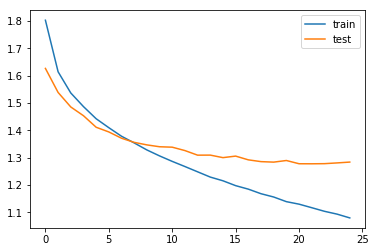

In [8]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

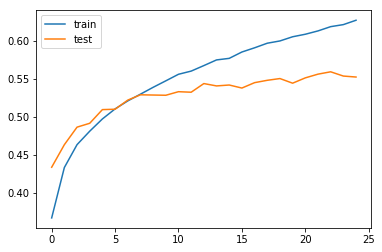

In [9]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()
plt.show()